In [2]:
import numpy as np
import tensorflow as tf
import re
import tqdm

D:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 加载数据

In [3]:
# 替换一些字符，所有字母变为小写
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [4]:
# 加载数据，并对数据做处理
def load_data(pos_data, neg_data):
    # 读入样本，将样本放入list中
    pos = list(open(pos_data, "r", encoding='utf-8').readlines())
    # strip()移除字符串头尾指定的字符（默认为空格或换行符）或字符序列
    pos = [s.strip() for s in pos]
    
    neg = list(open(neg_data, "r", encoding='utf-8').readlines())
    neg = [s.strip() for s in neg]

    x = pos + neg
    x = [clean_str(_) for _ in x]
    x = np.array(x)
    
    pos_label = [[0] for _ in pos]
    neg_label = [[1] for _ in neg]
    
    y = np.concatenate([pos_label, neg_label], axis=0) # axis=0 按行拼接
    y = np.array(y)
    # y = tf.concat(0, [pos_label, neg_label]) 也可以这样写 与上一行作用相同
    return [x, y]

In [5]:
print("加载数据ing...")
x, y = load_data("data/pos.txt", "data/neg.txt")

# 查看数据
print("评价平均长度: {}".format(np.mean([len(sentence.split()) for sentence in x])))
max_document_length = max([len(_.split(" ")) for _ in x]) # 找到最长的句子
print("最长的评价长度：{}".format(max_document_length))
min_document_length = min([len(_.split(" ")) for _ in x]) # 找到最长的句子
print("最短的评价长度：{}".format(min_document_length))

print(x.shape)
print(y.shape)

加载数据ing...
评价平均长度: 20.38585631213656
最长的评价长度：56
最短的评价长度：1
(10662,)
(10662, 1)


In [6]:
# 设置评价最大长度
TEXT_MAX_SIZE = 30

In [7]:
# 建立词典 key为单词 value为出现次数
voc_dic = {}
for sentence in x:
    words = sentence.split()
    for word in words:
        if word in voc_dic:
            voc_dic[word] += 1
        else:
            voc_dic[word] = 1

In [8]:
# 构建词表
vocab = ["<pad>", "<unk>"]

# 词频大于1的才加入词表
for k, v in voc_dic.items():
    if v > 1:
        vocab.append(k)

print('词典长度：{}'.format(len(vocab)))

词典长度：10112


In [9]:
# 构建单词到索引的映射(每个数字代表一个单词或一个符号)
word_to_index = {word: index for index, word in enumerate(vocab)}

# 索引到单词的映射：
index_to_word = {index: word for index, word in enumerate(vocab)}

In [10]:
# 定义一个将句子中每个word转换为index的函数：
def sentence_to_index(sentence, max_size=TEXT_MAX_SIZE, word_map=word_to_index):
    # unknown和pad的index
    unk_id = word_map["<unk>"]
    pad_id = word_map["<pad>"]
    
    # 转换
    sentence_index = [word_map.get(word, unk_id) for word in sentence.lower().split()]
    
    # 长度小于给定长度时，填充；长度大于给定长度时，截断。
    if len(sentence_index) < max_size:
        sentence_index.extend([0] * (max_size - len(sentence_index)))
    else:
        sentence_index = sentence_index[:max_size]
    
    return sentence_index

In [11]:
s = "I like this move very much ！ 。 / ， 。"
a = sentence_to_index(s)
print(a)

[328, 65, 144, 311, 1037, 180, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
# 所有训练样本 转化为索引格式
x_index = []
for _ in x:
    single_index = sentence_to_index(_)
    x_index.append(single_index)
x_index = np.array(x_index)
x_index.shape

(10662, 30)

In [13]:
with open("data/glove.6B.300d.txt", "r", encoding = "utf-8") as f:
    word_to_vec = {}
    i = 0
    for line in tqdm.tqdm(f):
        line = line.split()
        word_to_vec[line[0]] = np.array(line[1:], dtype=np.float32)

400000it [00:46, 8529.49it/s]


In [14]:
# 词表大小、embedding深度
VOCAB_SIZE = len(vocab)
EMBEDDING_SIZE = 300
VOCAB_SIZE

10112

In [15]:
# 初始化词向量矩阵，尺寸为 词表大小×embedding深度
original_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])

for word, index in word_to_index.items():
    # 用glove词向量填充矩阵，如果glove中没有该词，则随机给个数
    word_vec = word_to_vec.get(word, np.random.randn(EMBEDDING_SIZE) * np.sqrt(2/EMBEDDING_SIZE))
    # 词向量矩阵中行号就是词的index值，每个词用300个数表示
    original_embeddings[index, :] = word_vec

# 将pad的300个数全设为0
original_embeddings[word_to_index["<pad>"], :] = 0

original_embeddings = original_embeddings.astype(np.float32)

In [16]:
# 分出训练集和测试集
def generate_train_test(x, y, train_ratio=0.8, shuffle=True):
    
    assert x.shape[0] == y.shape[0], print("error shape!")
    
    if shuffle:
        # permutation函数：打乱顺序
        shuffle_indices = np.random.permutation(range(x.shape[0]))
        x = x[shuffle_indices]
        y = y[shuffle_indices]
        
    # 从样本中分出训练集和测试集
    train_size = int(x.shape[0] * train_ratio)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_test = x[train_size:]
    y_test = y[train_size:]
    
    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = generate_train_test(np.array(x_index), np.array(y))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8529, 30)
(8529, 1)
(2133, 30)
(2133, 1)


In [25]:
# 清空图
tf.reset_default_graph()


# 定义了5种filter，每种100个
filters_size = [2, 3, 4, 5, 6]
num_filters = 100
# 超参数
BATCH_SIZE = 256
EPOCHES = 50
LEARNING_RATE = 0.001
L2_LAMBDA = 10
KEEP_PROB = 0.8

In [26]:
# 分出mini_batch
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    
    assert x.shape[0] ==y.shape[0], print("error shape!")
    
    batches = []
    
    # 打乱顺序
    if shuffle:
        shuffle_indices = np.random.permutation(range(x.shape[0]))
        x = x[shuffle_indices]
        y = y[shuffle_indices]
    
    # batch数目（整数），如果剩下的样本不够一个batch，那在下面处理剩下的一部分
    batch_complete_num = int(x.shape[0] / batch_size)
    
    # 整数部分
    for k in range(batch_complete_num):
        batch_x = x[k*batch_size : (k+1)*batch_size, :] # 从k*batch_size到(k+1)*batch_size行,:代表所有列，
        batch_y = y[k*batch_size : (k+1)*batch_size, :]
        batch = (batch_x, batch_y)
        batches.append(batch)
    # 剩余部分
    if x.shape[0] % batch_size != 0:
        batch_x = x[batch_complete_num*batch_size : x.shape[0]]
        batch_y = y[batch_complete_num*batch_size : y.shape[0]]
        batch = (batch_x, batch_y)
        batches.append(batch)
    return batches

In [27]:
with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 30), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=original_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度，参数-1代表增加的维度是最后一个维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
        print(embedding_matrix.shape)
        print(embed.shape)
        print(embed_expanded.shape)
        
    
    # 用来存储max-pooling的结果
    pooled_outputs = []
 
    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")
            print(conv.shape)

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            print(a.shape)
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, TEXT_MAX_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            pooled_outputs.append(max_pooling)
            print(max_pooling.shape)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, KEEP_PROB)
    
    # output
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(predictions, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

(10112, 300)
(?, 30, 300)
(?, 30, 300, 1)
(?, 29, 1, 100)
(?, 29, 1, 100)
(?, 1, 1, 100)
(?, 28, 1, 100)
(?, 28, 1, 100)
(?, 1, 1, 100)
(?, 27, 1, 100)
(?, 27, 1, 100)
(?, 1, 1, 100)
(?, 26, 1, 100)
(?, 26, 1, 100)
(?, 1, 1, 100)
(?, 25, 1, 100)
(?, 25, 1, 100)
(?, 1, 1, 100)


## 训练模型

In [27]:
# 存储准确率
cnn_train_accuracy = []
cnn_test_accuracy = []

In [28]:
saver = tf.train.Saver()

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        cnn_train_accuracy.append(train_acc)
        
        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        cnn_test_accuracy.append(test_acc)
        
        print("Training epoch: {}, Training loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                                total_loss / n_batches,
                                                                                                                train_acc,
                                                                                                               test_acc))
    
    saver.save(sess, "checkpoints/cnn")
    writer.close()

Training epoch: 1, Training loss: 7.6261, Train accuracy: 0.7246, Test accuracy: 0.6929
Training epoch: 2, Training loss: 2.9033, Train accuracy: 0.7635, Test accuracy: 0.7018
Training epoch: 3, Training loss: 1.2488, Train accuracy: 0.7819, Test accuracy: 0.7211
Training epoch: 4, Training loss: 0.7856, Train accuracy: 0.7914, Test accuracy: 0.7412
Training epoch: 5, Training loss: 0.6696, Train accuracy: 0.7493, Test accuracy: 0.7131
Training epoch: 6, Training loss: 0.6332, Train accuracy: 0.7738, Test accuracy: 0.7511
Training epoch: 7, Training loss: 0.6073, Train accuracy: 0.7883, Test accuracy: 0.7600
Training epoch: 8, Training loss: 0.5913, Train accuracy: 0.7752, Test accuracy: 0.7450
Training epoch: 9, Training loss: 0.5768, Train accuracy: 0.7917, Test accuracy: 0.7609
Training epoch: 10, Training loss: 0.5653, Train accuracy: 0.7870, Test accuracy: 0.7487
Training epoch: 11, Training loss: 0.5563, Train accuracy: 0.7996, Test accuracy: 0.7651
Training epoch: 12, Training l

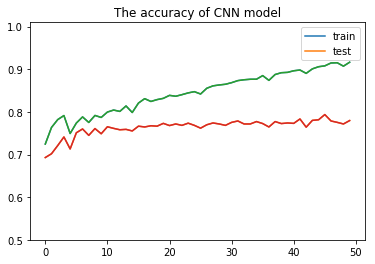

In [32]:
import matplotlib.pyplot as plt
plt.plot(cnn_train_accuracy)
plt.plot(cnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "test"])
plt.show()

In [33]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/cnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100 * total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/cnn
The LSTM model accuracy on test set: 77.45%


# CNN multi-channel

In [57]:
# 清空图
tf.reset_default_graph()

In [58]:
# 定义了5种filter，每种100个
filters_size = [2, 3, 4, 5, 6]
num_filters = 100
# 超参数
BATCH_SIZE = 256
EPOCHES = 9
LEARNING_RATE = 0.001
L2_LAMBDA = 10
KEEP_PROB = 0.8

In [59]:
with tf.name_scope("cnn_multichannels"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 30), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    # embeddings
    with tf.name_scope("embeddings"):
        # static embeddings
        static_embedding_matrix = tf.Variable(initial_value=original_embeddings, 
                                              trainable=False, 
                                              name="static_embedding_matrix")
        static_embed = tf.nn.embedding_lookup(static_embedding_matrix, inputs, name="static_embed")
        static_embed_expanded = tf.expand_dims(static_embed, -1, name="static_embed_expand")
        
        # non-static embeddings
        dynamic_embedding_matrix = tf.Variable(tf.random_normal(shape=(VOCAB_SIZE, EMBEDDING_SIZE), stddev=0.1), 
                                               trainable=True, 
                                               name="dynamic_embedding_matrix")
        dynamic_embed = tf.nn.embedding_lookup(dynamic_embedding_matrix, inputs, name="dynamic_embed")
        dynamic_embed_expanded = tf.expand_dims(dynamic_embed, -1, name="dynamic_embed_expand")
        
        # stack
        embed_expanded = tf.concat((static_embed_expanded, dynamic_embed_expanded), axis=-1, name="embed_expanded")
    
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            # 注意这里filter的channel要指定为2
            filter_shape = [filter_size, EMBEDDING_SIZE, 2, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, TEXT_MAX_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                   padding="VALID",
                                   name="max_pooling")
            pooled_outputs.append(max_pooling)
        
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, KEEP_PROB)
    
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(predictions, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [60]:
multi_cnn_train_accuracy = []
multi_cnn_test_accuracy = []

In [61]:
saver = tf.train.Saver()

In [62]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/multi_cnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        multi_cnn_train_accuracy.append(train_acc)
        
        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        multi_cnn_test_accuracy.append(test_acc)
        
        print("Training epoch: {}, Training loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                                total_loss / n_batches,
                                                                                                                train_acc,
                                                                                                                test_acc))
    
    saver.save(sess, "checkpoints/multi_cnn")
    writer.close()

Training epoch: 1, Training loss: 7.6033, Train accuracy: 0.7703, Test accuracy: 0.6976
Training epoch: 2, Training loss: 2.8780, Train accuracy: 0.8245, Test accuracy: 0.7150
Training epoch: 3, Training loss: 1.2345, Train accuracy: 0.8537, Test accuracy: 0.7332
Training epoch: 4, Training loss: 0.7600, Train accuracy: 0.8631, Test accuracy: 0.7468
Training epoch: 5, Training loss: 0.6400, Train accuracy: 0.8374, Test accuracy: 0.7473
Training epoch: 6, Training loss: 0.5876, Train accuracy: 0.8492, Test accuracy: 0.7722
Training epoch: 7, Training loss: 0.5403, Train accuracy: 0.8701, Test accuracy: 0.7759
Training epoch: 8, Training loss: 0.4962, Train accuracy: 0.8892, Test accuracy: 0.7754
Training epoch: 9, Training loss: 0.4509, Train accuracy: 0.9139, Test accuracy: 0.7881


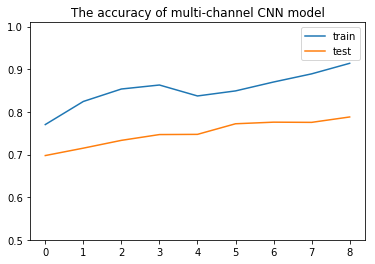

In [63]:
plt.plot(multi_cnn_train_accuracy)
plt.plot(multi_cnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of multi-channel CNN model")
plt.legend(["train", "test"])
plt.show()

In [64]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/multi_cnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The CNN model accuracy on test set: {:.2f}%".format(100 * total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/multi_cnn
The LSTM model accuracy on test set: 79.09%
